<a href="https://colab.research.google.com/github/slagathorr/cvdb/blob/main/CVDB_with_DuckDB_and_Malloy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

As a thought experiment, we thought we would see how easy or difficult it will be to take the [Open CVDB](https://github.com/wiz-sec/open-cvdb) files and load them into DuckDB to do some quick analysis. The source files are a series of YAML files ([located here](https://github.com/wiz-sec/open-cvdb/tree/main/vulnerabilities)) that we need to shoehorn into the database.

Spoiler alert, turns out it's pretty easy.

Also this is an updated notebook with [Malloy](https://www.malloydata.dev/)! If you haven't heard of this, the [quick Hello World video](https://www.youtube.com/watch?v=VQ0UFGSHV9o) is worth a watch

# Setup

This uses PyYAML, but it's already installed with Colab.

This uses DuckDB, but it's already installed with Colab.

We do need to install Malloy, though!

In [25]:
# Fetch the files.

!rm -rf /my_computer
!git clone https://github.com/wiz-sec/open-cvdb.git /my_computer
!mkdir  /my_computer/vulnerabilities_json/

# Some of the YAMLs in the repository have quotes that invalidate the YAML,
# so this removes them.
!find /my_computer/vulnerabilities/. -type f -exec sed -i 's/"//g' {} \;

Cloning into '/my_computer'...
remote: Enumerating objects: 2419, done.
remote: Counting objects: 100% (2419/2419), done.
remote: Compressing objects: 100% (1011/1011), done.
remote: Total 2419 (delta 1475), reused 2299 (delta 1389), pack-reused 0
Receiving objects: 100% (2419/2419), 35.75 MiB | 31.72 MiB/s, done.
Resolving deltas: 100% (1475/1475), done.


In [26]:
# Hit the library.

!pip install -q malloy
%reload_ext malloy

import yaml
import json
import os
from google.colab import data_table

data_table.enable_dataframe_formatter()

Malloy out
Malloy ahoy


Let's process the files and convert them to JSON.

In [27]:
# Iterate through the YAML files, read them into a native Python data type, and write out JSON.

for filename in os.listdir('/my_computer/vulnerabilities/'):
  filename_yaml = "/my_computer/vulnerabilities/" + filename
  print("Starting: ", filename)
  filename_json = "/my_computer/vulnerabilities_json/" + filename.replace("yaml", "json")
  with open(filename_yaml, 'r') as yaml_in, open(filename_json, "w") as json_out:
    yaml_object = yaml.safe_load(yaml_in) # yaml_object will be a list or a dict
    json.dump(yaml_object, json_out)
  print("Wrote: ", filename_json)

Starting:  data_gateway_rce.yaml
Wrote:  /my_computer/vulnerabilities_json/data_gateway_rce.json
Starting:  cve-2022-29149.yaml
Wrote:  /my_computer/vulnerabilities_json/cve-2022-29149.json
Starting:  dataflow-rce-jmx.yaml
Wrote:  /my_computer/vulnerabilities_json/dataflow-rce-jmx.json
Starting:  badbuild.yaml
Wrote:  /my_computer/vulnerabilities_json/badbuild.json
Starting:  notlegit.yaml
Wrote:  /my_computer/vulnerabilities_json/notlegit.json
Starting:  asset-key-thief.yaml
Wrote:  /my_computer/vulnerabilities_json/asset-key-thief.json
Starting:  superglue.yaml
Wrote:  /my_computer/vulnerabilities_json/superglue.json
Starting:  aws-package-backfill.yaml
Wrote:  /my_computer/vulnerabilities_json/aws-package-backfill.json
Starting:  azure_multiple_ssrf.yaml
Wrote:  /my_computer/vulnerabilities_json/azure_multiple_ssrf.json
Starting:  terms-conditions-customer-data.yaml
Wrote:  /my_computer/vulnerabilities_json/terms-conditions-customer-data.json
Starting:  gcp-2022-011.yaml
Wrote:  /my

# DuckDB Time!

Let's first take a look at a file and see what they look like.

In [28]:
!cat /my_computer/vulnerabilities/autowarp.yaml

title: AutoWarp
slug: autowarp
cves: null
affectedPlatforms:
- Azure
affectedServices:
- Automation Service
image: https://images.unsplash.com/photo-1651491602333-fea83f1d9107?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80
severity: Critical
piercingIndexVector: {version: 1.5, A1: 20, A2: 1.21, A7: 1.1, A8: 1.1}
discoveredBy:
  name: Yanir Tsarimi
  org: Orca Security
  domain: https://orca.security/
  twitter: null
publishedAt: 2022/03/07
disclosedAt: 2021/12/06
exploitabilityPeriod: null
knownITWExploitation: false
summary: |
  An exposed endpoint in the Azure Automation Service allowed to steal Azure
  API credentials from other customers
manualRemediation: |
  None required. As a general practice, use the least-privilege
  principle, including on managed identities assigned to automation accounts. While
  this would not have prevented the leakage of API credentials, it would have reduced
  the blast radius.
detectionMethods: null
c

## Let's fetch a duck!

## Create and load table

Load up a DuckDB instance, and start digging.

We are manually defining a schema because while the structure is consistent, the data values are necessarily not. As an example, there are instances where the `knownITWExploitation` field is set to a `STRING` of "No" and others where it's a `BOOL` of `false`. The auto detect functions would set this as a `BOOL` and error out when it hit strings. There are other data types like that as well.

In [29]:
import duckdb
conn = duckdb.connect()

conn.execute("""
CREATE OR REPLACE TABLE vulns AS (
  SELECT * FROM READ_JSON_AUTO('/my_computer/vulnerabilities_json/*.json', columns={
    title:  'VARCHAR',
    slug:   'VARCHAR',
    cves:   'VARCHAR[]',
    affectedPlatforms:  'VARCHAR[]',
    affectedServices:   'VARCHAR[]',
    image:  'VARCHAR',
    severity:           'VARCHAR',
    discoveredBy:       'STRUCT(name VARCHAR, org VARCHAR, domain VARCHAR, twitter JSON)',
    disclosedAt:        'DATE',
    publishedAt:        'DATE',
    exploitabilityPeriod:   'JSON',
    knownITWExploitation:   'VARCHAR',
    summary:            'VARCHAR',
    manualRemediation:  'VARCHAR',
    detectionMethods:   'JSON',
    contributor:        'VARCHAR',
    "references":       'VARCHAR[]',
    piercingIndexVector:  'STRUCT(version DOUBLE, A1 BIGINT, A2 DOUBLE, A7 DOUBLE, A8 DOUBLE)'
    }, ignore_errors=true
                        ));
""")

conn.execute("""
DESCRIBE vulns;
""").fetchdf()

,column_name,column_type,null,key,default,extra
0,title,VARCHAR,YES,None,None,NaN
1,slug,VARCHAR,YES,None,None,NaN
2,cves,VARCHAR[],YES,None,None,NaN
3,affectedPlatforms,VARCHAR[],YES,None,None,NaN
4,affectedServices,VARCHAR[],YES,None,None,NaN
5,image,VARCHAR,YES,None,None,NaN
6,severity,VARCHAR,YES,None,None,NaN
7,discoveredBy,"STRUCT(""name"" VARCHAR, org VARCHAR, ""domain"" V...",YES,None,None,NaN
8,disclosedAt,DATE,YES,None,None,NaN
9,publishedAt,DATE,YES,None,None,NaN


## Verify

In [30]:
# Let's see the data.

conn.execute("SELECT * FROM vulns LIMIT 3").fetchdf()

,title,slug,cves,affectedPlatforms,affectedServices,image,severity,discoveredBy,disclosedAt,publishedAt,exploitabilityPeriod,knownITWExploitation,summary,manualRemediation,detectionMethods,contributor,references,piercingIndexVector
0,ACSESSED,acsessed,NaN,[Azure],[Cognitive Search],https://raw.githubusercontent.com/wiz-sec/open...,Medium,"{'name': 'Emilien Socchi', 'org': 'mnemonic', ...",2022-02-23,2022-12-22,None,false,Azure Cognitive Search (ACS) is a full-text se...,None required\n,None,https://github.com/techbrunch,[https://www.mnemonic.io/resources/blog/acsess...,"{'version': 1.5, 'A1': 20, 'A2': 1.0, 'A7': 1...."
1,Overprivileged CodeBuild default ECR IAM policy,aws-codebuild-ecr-iam-vuln,NaN,[AWS],"[AWS CodeBuild, AWS ECR]",https://raw.githubusercontent.com/wiz-sec/open...,medium,"{'name': 'Will Deane', 'org': 'ASX Consulting'...",2022-07-04,2023-02-25,"""Until July 26, 2022""",None,"For AWS CodeBuild, when using a custom contain...",For any CodeBuild projects created before July...,None,https://github.com/willdeane,[https://www.asxconsulting.co.uk/blog/codebuild/],"{'version': 1.5, 'A1': None, 'A2': None, 'A7':..."
2,XSS in Azure Bastion and Container Registry,bastion-container-reg-xss,NaN,[Azure],"[Azure Bastion, Azure Container Registry]",https://raw.githubusercontent.com/wiz-sec/open...,High,"{'name': 'Lidor Ben Shitrit', 'org': 'Orca Sec...",2023-04-13,2023-06-14,None,false,Orca discovered vulnerabilities in Azure Basti...,None required\n,None,https://github.com/korniko98,[https://orca.security/resources/blog/examinin...,"{'version': 1.5, 'A1': 20, 'A2': 1.1, 'A7': 1...."


In [31]:
# Quick verification to see if the previous YAML (autowarp) we looked at matches.

conn.execute("""
SELECT * FROM vulns
WHERE title = 'AutoWarp';
""").fetchdf()

,title,slug,cves,affectedPlatforms,affectedServices,image,severity,discoveredBy,disclosedAt,publishedAt,exploitabilityPeriod,knownITWExploitation,summary,manualRemediation,detectionMethods,contributor,references,piercingIndexVector
0,AutoWarp,autowarp,NaN,[Azure],[Automation Service],https://images.unsplash.com/photo-165149160233...,Critical,"{'name': 'Yanir Tsarimi', 'org': 'Orca Securit...",2021-12-06,2022-03-07,None,false,An exposed endpoint in the Azure Automation Se...,"None required. As a general practice, use the ...",None,https://github.com/christophetd,[https://orca.security/resources/blog/autowarp...,"{'version': 1.5, 'A1': 20, 'A2': 1.21, 'A7': 1..."


# Analysis Time... but with Malloy!

It looks like it works! Let's ask some questions.

But this time, we're going to use Malloy.

There's two things we're going to do. The first is to output our table in DuckDB to a Parquet file, and then create a Malloy model that just has our source declaration in it. As of this writing, Malloy can't directly source a table in DuckDB, and you can only use it to source external files. Also, it's important to note that in the Python/Jupyter libraries for Malloy, you first have to declare a model and run your queries against that. In other environments you may find examples where queries are run directly with the source declaration in it, but this environment requires a separate model with the source in it.

In [32]:
!rm -rf /my_computer/duckdb_data/
!mkdir /my_computer/duckdb_data/
conn.sql("COPY vulns TO '/my_computer/duckdb_data/vulns.parquet' (FORMAT PARQUET);")

In [33]:
%%malloy_model cvdb
source: vulns is duckdb.table('/my_computer/duckdb_data/vulns.parquet')

We're now going to run the queries we ran in SQL to answer some questions, and get the same result using Malloy so we can compare and contrast.

## How many vulnerabilities were disclosed per month?

### SQL

Let's first run this in SQL.

<Axes: xlabel='month'>

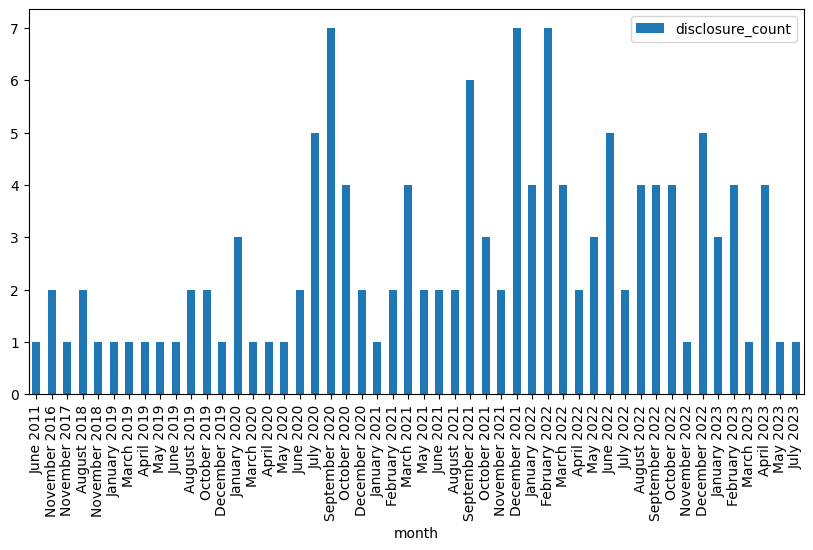

In [34]:
# How many vulnerabilities were disclosed per month?

results=conn.execute("""
SELECT
  count(*) AS disclosure_count,
  STRFTIME(DATE_TRUNC('month',disclosedAt),'%B %Y') AS month,
  DATE_TRUNC('month', disclosedAt) AS month_datetime
  FROM vulns
  WHERE month IS NOT NULL
  GROUP BY month_datetime
  ORDER BY month_datetime asc;
""").fetchdf()

results.plot(x="month", y="disclosure_count", kind="bar", figsize=(10, 5))

### Malloy

Below we're going to write the same query in Malloy, and try to get the same plot. We will be querying the `cvdb` model declared above, and output the data to a dataframe called `vulns_output`.

In [35]:
%%malloy_query cvdb vulns_output
run: vulns -> {
  aggregate:
    disclosure_count is count()
  group_by:
    month_datetime is disclosedAt.month::date
  order_by:
    month_datetime ASC
  where: disclosedAt != null
}

✅ Stored in vulns_output


<Axes: xlabel='month_datetime'>

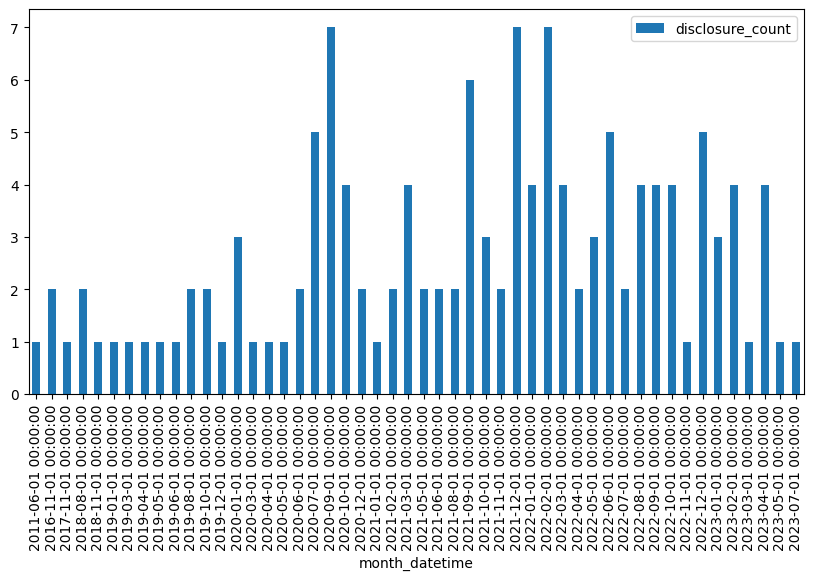

In [36]:
vulns_output.plot(x="month_datetime", y="disclosure_count", kind="bar", figsize=(10, 5))

Note that we output the results to a dataframe called `vulns_output` and then plotted it using Pandas. Malloy has built in visualization capabilities and we can directly output the results to a bar chart by simply removing the output declaration and including the `# bar_chart` tag, as shown below.

In [37]:
%%malloy_query cvdb
# bar_chart
run: vulns -> {
  aggregate:
    disclosure_count is count()
  group_by:
    month_datetime is disclosedAt.month::date
  order_by:
    month_datetime ASC
  where: disclosedAt != null
}

## Are there really disclosures with no disclosure times?

At the time of writing, we are finding that there are entires of `nan` on our histogram. Which makes us wonder, are there really disclosures that don't have time associated with them?

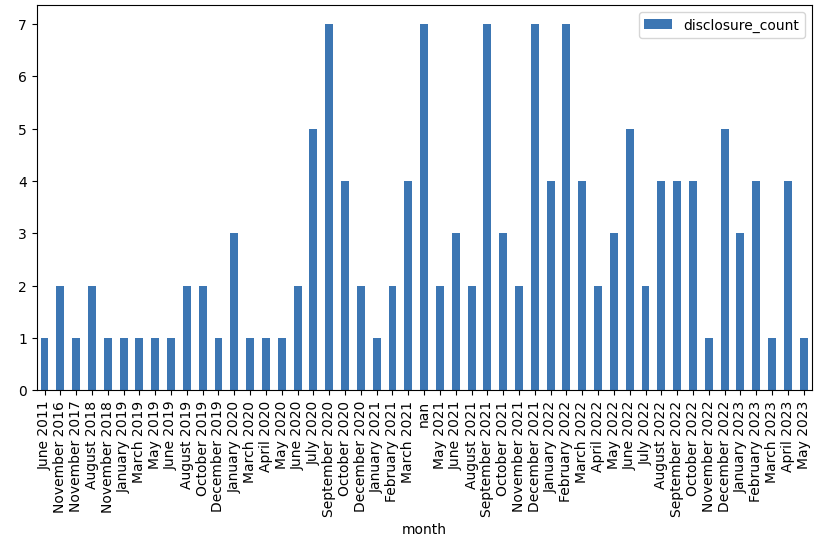

Let's see what the data actually looks like.

In [38]:
conn.execute("SELECT * FROM vulns WHERE disclosedat IS NULL").fetchdf()

,title,slug,cves,affectedPlatforms,affectedServices,image,severity,discoveredBy,disclosedAt,publishedAt,exploitabilityPeriod,knownITWExploitation,summary,manualRemediation,detectionMethods,contributor,references,piercingIndexVector
0,GCP Cloudshell Cross-Site WebSocket Hijacking ...,gcp-cloudshell-cswsh,NaN,[GCP],[GCP Cloudshell],https://images.unsplash.com/photo-1543789289-2...,Low,"{'name': 'Psi', 'org': None, 'domain': 'ψ.fun'...",NaT,2020-03-11,None,false,Google Cloudshell leveraged websockets without...,null\n,None,https://github.com/ramimac,"[https://ψ.fun/i/yvpMj, https://security.googl...",NaN
1,Dropped active Google Cloud Armor security policy,gcp-2021-019,NaN,[GCP],[Cloud Armor],https://images.unsplash.com/photo-160721723722...,Low,"{'name': None, 'org': None, 'domain': None, 't...",NaT,2021-09-29,None,None,There is a known issue where updating a Backen...,Dropped Cloud Armor security policies must be ...,None,https://github.com/ramimac,[https://cloud.google.com/support/bulletins#gc...,NaN
2,Open In Google Cloud Shell command injection,gcp-cloudshell-open-in-command-injection,NaN,[GCP],[Google Cloud Shell],https://images.unsplash.com/photo-154142791420...,Medium,"{'name': 'Ademar Nowasky Junior', 'org': None,...",NaT,2021-12-28,"""Until 2021/01/23""",false,A vulnerability was discovered in Cloud Shell ...,None required\n,None,https://github.com/ramimac,[https://docs.google.com/document/d/1-TTCS6fS6...,NaN
3,Predictible seed in Anthos Identity Service LD...,gcp-2021-022,NaN,[GCP],[Anthos],https://images.unsplash.com/photo-145801485481...,Low,"{'name': None, 'org': None, 'domain': None, 't...",NaT,2021-09-22,"""Ongoing""",None,A vulnerability was discovered in the Anthos I...,Upgrade your clusters to version 1.8.2.\n,None,https://github.com/ramimac,[https://cloud.google.com/support/bulletins#gc...,NaN
4,Bad.Build,badbuild,NaN,[GCP],[Cloud Build],https://raw.githubusercontent.com/wiz-sec/open...,Low,"{'name': 'Roi Nisimi', 'org': 'Orca Security',...",NaT,2023-07-18,None,false,An information disclosure vulnerability in the...,None required\n,None,https://github.com/korniko98,[https://cloud.google.com/build/docs/security-...,NaN
5,GCP Stackdriver Debugger SSRF,gcp-stackdriver-ssrf,NaN,[GCP],[GCP Stackdriver Debugger],https://images.unsplash.com/photo-160182953426...,Low,"{'name': 'Ron Chan', 'org': None, 'domain': 'h...",NaT,2019-12-19,None,None,An SSRF bug in GCP's Stackdriver Debugger feat...,None required\n,None,https://github.com/ramimac,[https://ngailong.wordpress.com/2019/12/19/goo...,NaN
6,Azure App Service on Azure Stack Hub privilege...,cve-2023-21777,NaN,[Azure],[Azure App Service on Azure Stack Hub],https://raw.githubusercontent.com/wiz-sec/open...,Medium,"{'name': 'Ruslan Sayfiev, Denis Faiustov', 'or...",NaT,2023-02-14,None,false,A privilege escalation vulnerability was disco...,Users of Azure App Service on Azure Stack Hub ...,None,https://github.com/mer-b,[https://msrc.microsoft.com/update-guide/en-US...,NaN
7,SSRF in Google Cloud Monitoring,ssrf-in-google-cloud-monitoring,NaN,[GCP],[Google Cloud Monitoring],https://images.unsplash.com/photo-159085602982...,Medium,"{'name': 'David Nechuta', 'org': None, 'domain...",NaT,2020-11-12,None,None,An SSRF bug in Google Cloud Monitoring's uptim...,None required\n,None,https://github.com/0xdabbad00,[https://nechudav.blogspot.com/2020/11/31k-ssr...,NaN
8,Signature version 1 (SigV1) is insecure,aws-sigv1-insecure,NaN,[AWS],NaN,https://c4.wallpaperflare.com/wallpaper/600/33...,Medium,"{'name': 'Colin Percival', 'org': None, 'domai...",NaT,2008-12-18,"""until December 18th, 2008""",false,"When making authenticated API requests to AWS,...","None required, SigV1 is deprecated at this poi...",None,https://github.com/ramimac,[http://www.daemonology.net/blog/2008-12-18-AW...,NaN
9,SNS SigningCertUrl improper validation,sns-signingcerturl-improper-validation,NaN,[AWS],[Amazon Simple Notification Service (SNS)],https://images.unsplash.com/photo-161109578012...,Medium,"{'name': 

Here we find that there are indeed instances where that is the case. On a side note, we also see that the `exploitabilityPeriod` field is also very much free form, which can make analysis of it somewhat of a challenge.

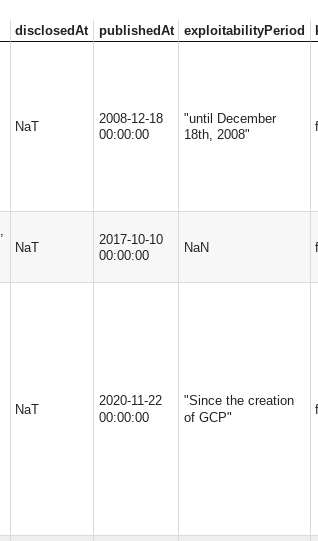

## How many vulnerabilities were published per month?

After chatting with a friend who knows security things more than I do, it looks like the publish date is going to be the one we really want to look at, and the data itself should be more complete. Let's try this one.

Note that the query is just a swap of a column of the vulnerabilities disclosed per month query, so we won't redo this in Malloy.

<Axes: xlabel='month'>

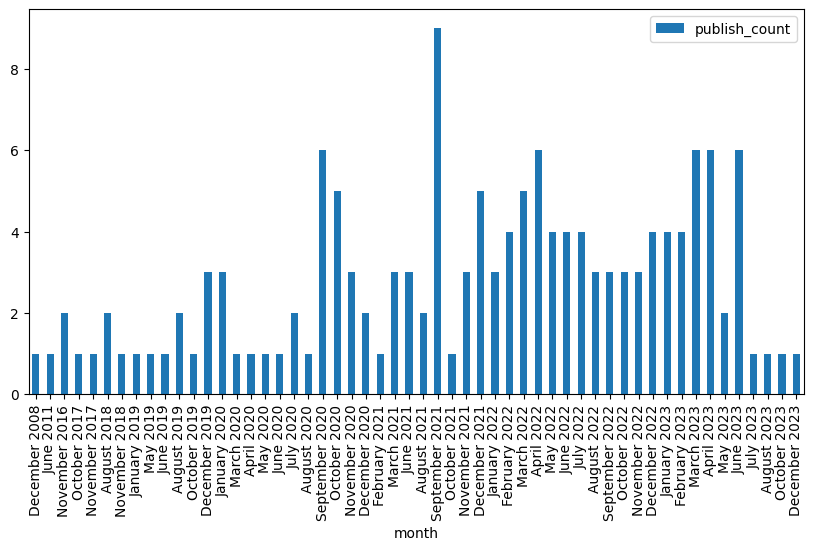

In [39]:
# How many vulnerabilities were published per month?

results=conn.execute("""
SELECT
  count(*) AS publish_count,
  STRFTIME(DATE_TRUNC('month',publishedAt),'%B %Y') AS month,
  DATE_TRUNC('month', publishedAt) AS month_datetime
  FROM vulns
  GROUP BY month_datetime
  ORDER BY month_datetime asc;
""").fetchdf()

results.plot(x="month", y="publish_count", kind="bar", figsize=(10, 5))

## What cloud platforms have the most vulnerabilities?

### SQL

Let's first do this in SQL.

   count cloud_platform
0     67            AWS
1      1        Alibaba
2     47          Azure
3     33            GCP
4      1            IBM
5      2            OCI


<Axes: ylabel='count'>

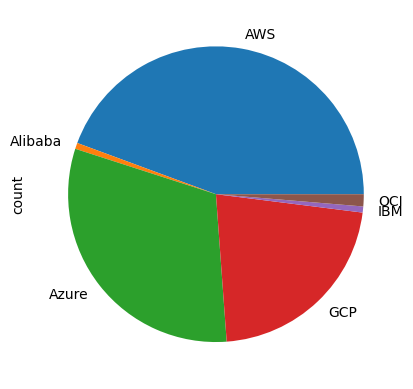

In [40]:
results=conn.execute("""
  WITH unnested_platforms AS (
    SELECT UNNEST(affectedPlatforms) AS cloud_platform
    FROM vulns)
  SELECT count(*) AS count, cloud_platform FROM unnested_platforms
  GROUP BY cloud_platform
  ORDER BY cloud_platform ASC
""").fetchdf()

print(results)
results.groupby(['cloud_platform']).sum().plot.pie(y="count", legend=None)

### Malloy

Now let's see how this looks in Malloy.

Note that Malloy doesn't yet have pie charts as a native visualization, so we will output the results into a dataframe and use Pandas to graph it.

In [41]:
%%malloy_query cvdb platform_count
run: vulns -> {
  aggregate: platform_count is count()
  group_by: cloud_platform is affectedPlatforms.value
  order_by: cloud_platform
}

✅ Stored in platform_count


   platform_count cloud_platform
0              67            AWS
1               1        Alibaba
2              47          Azure
3              33            GCP
4               1            IBM
5               2            OCI


<Axes: ylabel='platform_count'>

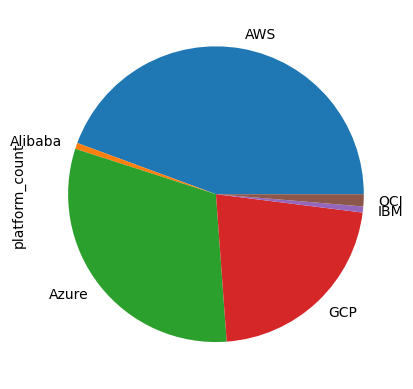

In [42]:
print(platform_count)
platform_count.groupby(['cloud_platform']).sum().plot.pie(y="platform_count", legend=None)

So one of the interesting things to note here is that if you look at the model, it treats the `affectedPlatforms` column as a relationship.

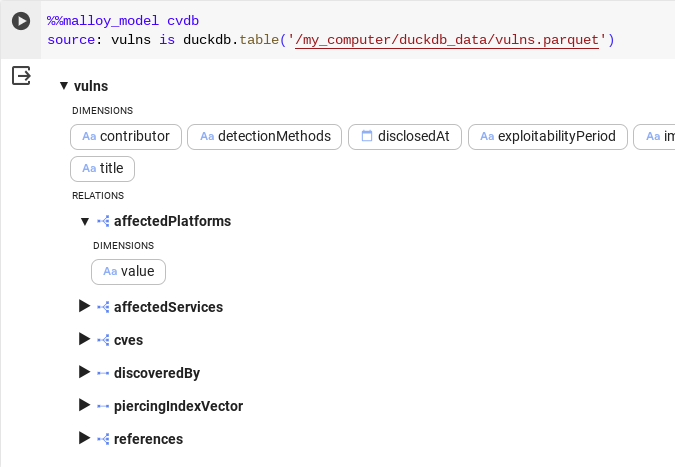

In the original database table, this is a repeated/list column. If you run the query again below and look at the SQL output, Malloy knows how to properly deal with that relationship since we are grouping by the individual elements within the list. Pretty nice if you ask me!

In [43]:
%%malloy_query cvdb
run: vulns -> {
  aggregate: platform_count is count()
  group_by: cloud_platform is affectedPlatforms.value
  order_by: cloud_platform
}

platform_​count,cloud_​platform
67,AWS
1,Alibaba
47,Azure
33,GCP
1,IBM
2,OCI


## What services have the most vulnerabilities?

Let's do the same thing with the services.

<Axes: xlabel='services'>

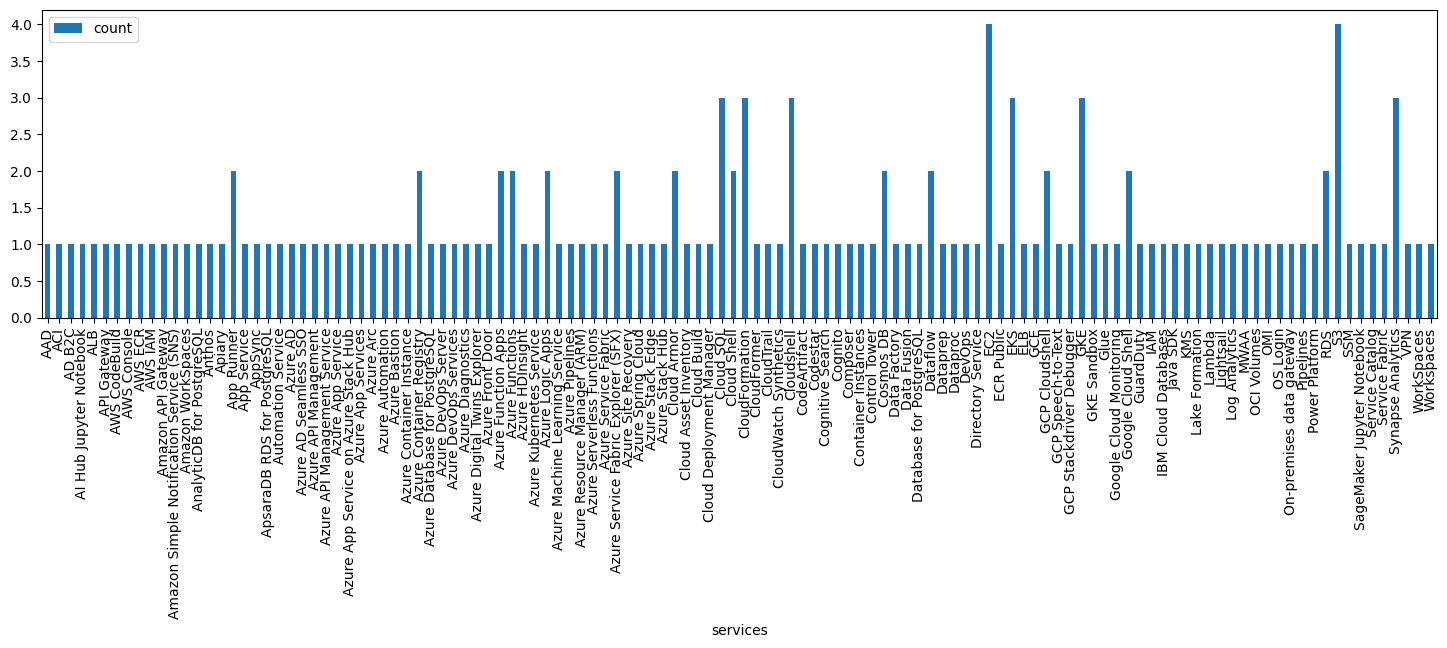

In [44]:
results=conn.execute("""
  WITH unnested_services AS (
    SELECT UNNEST(affectedServices) AS services
    FROM vulns)
  SELECT count(*) AS count, services FROM unnested_services
  GROUP BY services
  ORDER BY services ASC
""").fetchdf()

results.groupby(['services']).sum().plot.bar(y="count", figsize=(18, 4))

# More Malloy

Okay, so far we've just been using Malloy to replace some SQL queries directly. Personally, I always learn by example so while it doesn't show what Malloy can really do, it got my feet wet with the basic syntax and showed a little of how the structure of the queries work. Let's go into a little more of how I would imagine Malloy is supposed to add value, not by merely replicating SQL query logic 1:1.

## Define the Model

This is the first thing we will do. It will include the source definition as well as our main metric, which is always a count of everything.

We're also creating some derived metrics, as well as adding a [view](https://docs.malloydata.dev/documentation/language/views) which calculates the top three affected services per platform.

We also have `by_month` which gives us a quick [line chart](https://docs.malloydata.dev/documentation/visualizations/charts_line_chart).

In [71]:
%%malloy_model cvdb_model
source: vulns is duckdb.table('/my_computer/duckdb_data/vulns.parquet') extend {
  measure:
    vulnerability_count is count()
    average_disclose_diff_days is round(avg(publish_disclose_diff_days))
  dimension:
    disclosed_month is disclosedAt.month::date
    published_month is publishedAt.month::date
    publish_disclose_diff_days is days(disclosedAt to published_month)
  where: disclosedAt != null

  view: top_three is {
    group_by: service_name is affectedServices.value
    aggregate: service_vulnerability_count is vulnerability_count
    limit: 3
    where: affectedServices.value != null
  }

  # line_chart
  view: by_month is {
    group_by: disclosed_month
    aggregate: vulnerability_count
    order_by: disclosed_month asc
  }
}

## Query the Model

From here, we can see that the readability of the model is pretty good. It's easy and quick to see what the measures and dimensions are, as well as any filters that are placed. Let's get a quick query to see a simple calculation.

In [59]:
# This query gets us the number of total vulnerabilities, as well as the
# average discosure to publish day difference per vulnerability.
%%malloy_query cvdb_model
run: vulns -> {
  aggregate:
    vulnerability_count
    average_disclose_diff_days
  group_by: affectedPlatforms.value
}

vulnerability_​count,average_​disclose_​diff_​days,value
63,53,AWS
46,94,Azure
22,156,GCP
2,39,OCI
1,118,Alibaba
1,98,IBM


Now let's [nest](https://docs.malloydata.dev/documentation/language/nesting) the top three services that are affected per platform, and add that so we can quickly see some summary statistics.

In [60]:
%%malloy_query cvdb_model
run: vulns -> {
  aggregate: vulnerability_count
  group_by: affectedPlatforms.value
  nest: top_three
}

Now let's add a small line chart so that we can get general trends at a glance.

In [72]:
%%malloy_query cvdb_model
run: vulns -> {
  aggregate: vulnerability_count
  group_by: affectedPlatforms.value
  nest:
    by_month
    top_three
}

Hopefully this helps get your feet wet with Malloy, and how the framework makes you think a little bit more composable than SQL normally lets you.

Thanks for reading!